In [1]:
#IMPORT DELLE LIBRERIE
import numpy as np 
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt

import skimage.transform as trans
from skimage import io, color
from skimage.util import random_noise

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from sklearn.datasets import fetch_lfw_people
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
#DOWNLOAD DEL DATASET
lfw_dataset=fetch_lfw_people(resize=0.256,download_if_missing=True,slice_=None,color=True)
print(lfw_dataset.images.shape)
X=lfw_dataset.images
y=lfw_dataset.target


#SPLIT DEL DATASET PER IL TEST SET
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2)

#SPLIT DEL DATASET PER IL VALIDATION SET
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.1)

(13233, 64, 64, 3)


In [3]:
#DIMENSIONI DEL TRAINING SET
X_train.shape

(9527, 64, 64, 3)

In [4]:
#DIMENSIONI DEL TEST SET
X_test.shape

(2647, 64, 64, 3)

In [5]:
#DIMENSIONI DEL VALIDATION SET
X_val.shape

(1059, 64, 64, 3)

In [6]:
#AGGIUNGIAMO IL RUMORE ALLE IMMAGINI
noise_factor = 0.2

X_train_noisy = random_noise(X_train, mode="s&p",clip=True, amount=noise_factor)
X_test_noisy = random_noise(X_test, mode="s&p",clip=True, amount=noise_factor)
X_val_noisy = random_noise(X_val, mode="s&p",clip=True, amount=noise_factor)

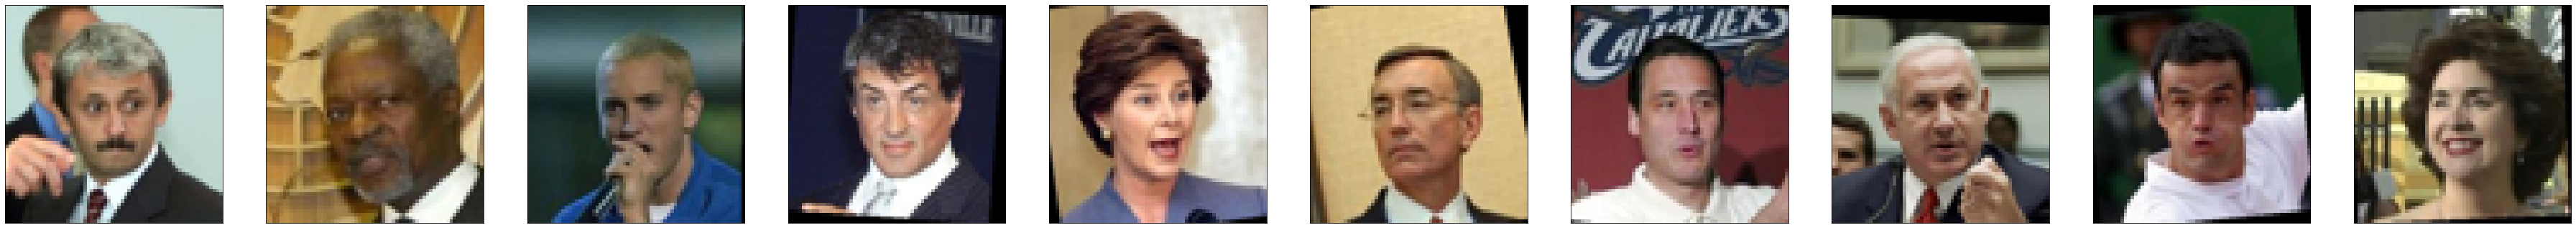

In [7]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

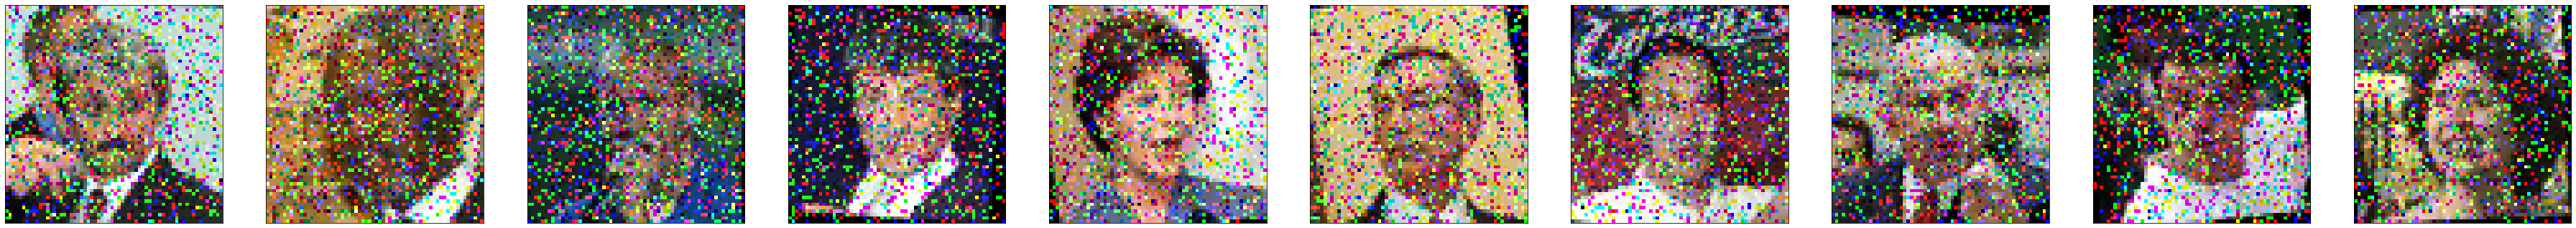

In [8]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TRAINING SET COL RUMORE
n = 10

plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train_noisy[i].reshape(64, 64,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [48]:
def EAM(input):

  x=Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')(input)
  x=Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')(x)

  y=Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')(input)
  y=Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')(y)

  z=Concatenate(axis=-1)([x,y])
  z=Conv2D(64, (3,3),padding='same',activation='relu')(z)
  add_1=Add()([z, input])

  z=Conv2D(64, (3,3),padding='same',activation='relu')(add_1)
  z=Conv2D(64, (3,3),padding='same')(z)
  add_2=Add()([z,add_1])
  add_2 = Activation('relu')(add_2)

  z=Conv2D(64, (3,3),padding='same',activation='relu')(add_2)
  z=Conv2D(64, (3,3),padding='same',activation='relu')(z)
  z=Conv2D(64, (1,1),padding='same')(z)
  add_3=Add()([z,add_2])
  add_3 = Activation('relu')(add_3)

  z = GlobalAveragePooling2D()(add_3)
  z = tf.expand_dims(z,1)
  z = tf.expand_dims(z,1)
  z=Conv2D(4, (3,3),padding='same',activation='relu')(z)
  z=Conv2D(64, (3,3),padding='same',activation='sigmoid')(z)
  mul=Multiply()([z, add_3])

  return mul

In [54]:
def RIDNET():

  input = Input((64, 64, 3),name='input')
  feat_extraction =Conv2D(64, (3,3),padding='same')(input)
  eam_1=EAM(feat_extraction)
  eam_2=EAM(eam_1)
  eam_3=EAM(eam_2)
  eam_4=EAM(eam_3)
  x=Conv2D(3, (3,3),padding='same')(eam_4)
  add_2=Add()([x, input])
  
  model=Model(input,add_2)

  return model

In [55]:
model = RIDNET()

In [56]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'mse')

In [57]:

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_626 (Conv2D)            (None, 64, 64, 64)   1792        ['input[0][0]']                  
                                                                                                  
 conv2d_627 (Conv2D)            (None, 64, 64, 64)   36928       ['conv2d_626[0][0]']             
                                                                                                  
 conv2d_629 (Conv2D)            (None, 64, 64, 64)   36928       ['conv2d_626[0][0]']             
                                                                                            

In [67]:
#TRAINING DEL MODELLO
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=3)
history = model.fit(X_train_noisy, X_train, epochs=100, batch_size=16, validation_data=(X_val_noisy,X_val), callbacks=[callback])

Epoch 1/100
596/596 [==============================] - 118s 197ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 2/100
596/596 [==============================] - 118s 198ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 3/100
596/596 [==============================] - 117s 196ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/100
596/596 [==============================] - 117s 196ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/100
596/596 [==============================] - 117s 196ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/100
596/596 [==============================] - 117s 196ms/step - loss: 0.0012 - val_loss: 9.6824e-04
Epoch 7/100
596/596 [==============================] - 118s 198ms/step - loss: 0.0010 - val_loss: 8.8859e-04
Epoch 8/100
596/596 [==============================] - 117s 196ms/step - loss: 9.2296e-04 - val_loss: 9.2261e-04
Epoch 9/100
596/596 [==============================] - 117s 196ms/step - loss: 8.5701e-04 - val_loss: 7.2666e-04
Epoch 10/100
596/596 [=========

In [68]:
#TEST DEL MODELLO SUL TEST SET
predict = model.predict(X_test_noisy)

83/83 [==============================] - 10s 120ms/step


In [69]:
predict.shape

(2647, 64, 64, 3)

In [70]:
n=10

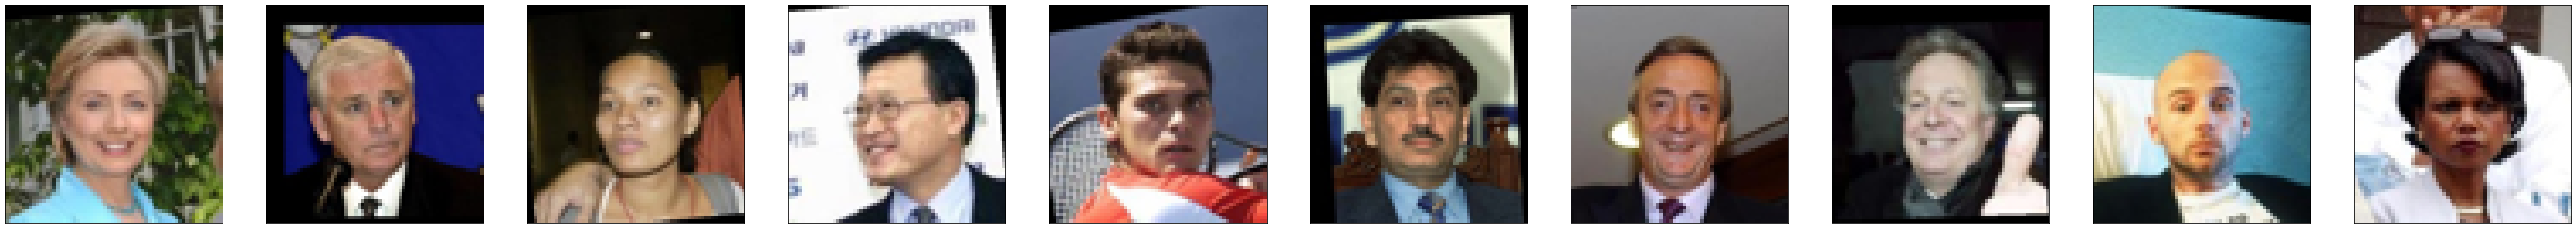

In [71]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

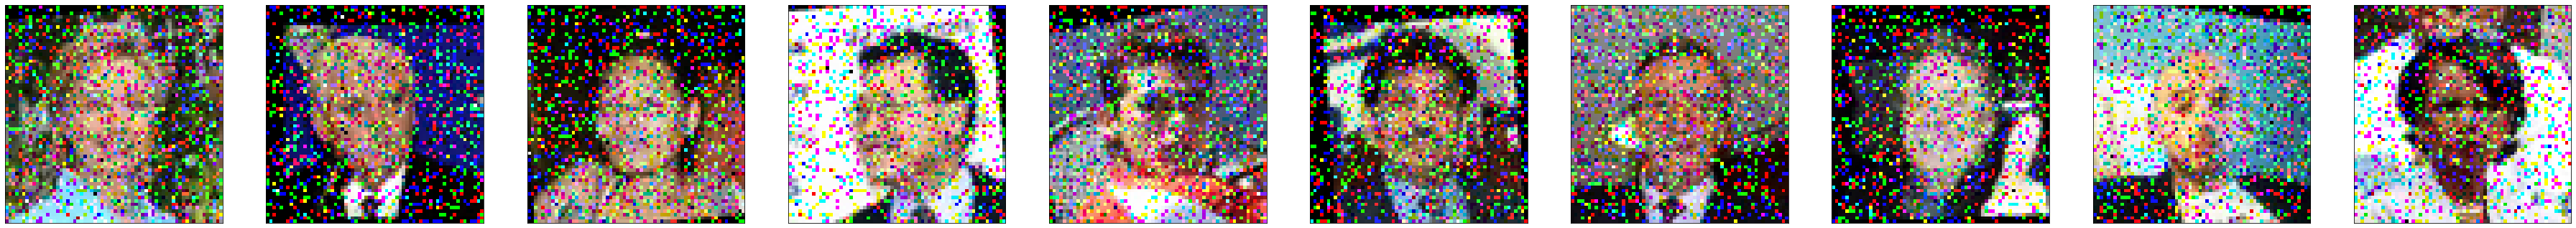

In [72]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET COL RUMORE
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

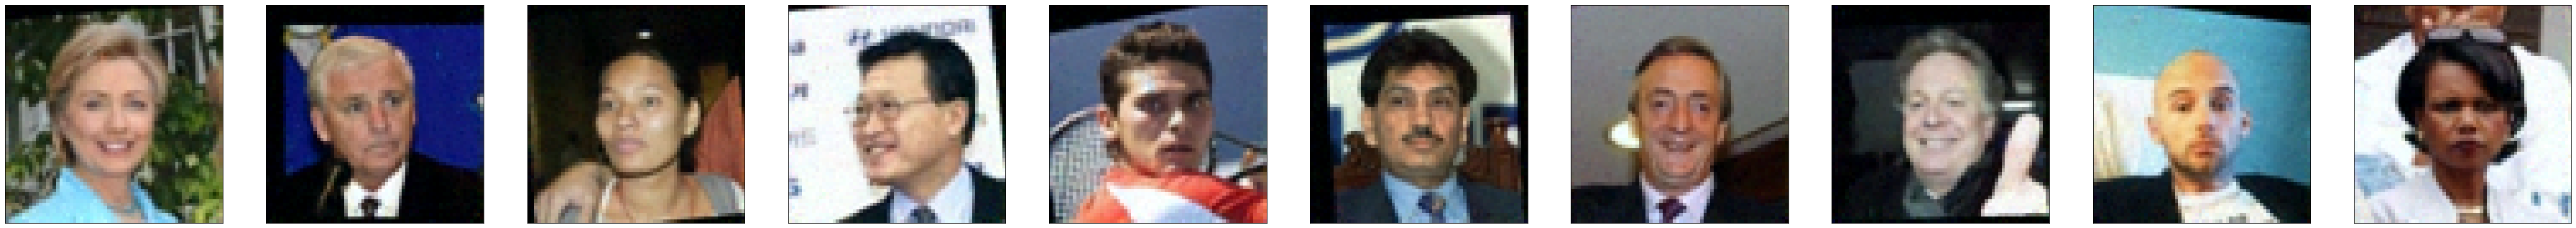

In [73]:
#STAMPO LE PRIME DIECI IMMAGINI DEL TEST SET SENZA RUMORE (OUTPUT DELLA UNET)
plt.figure(figsize=(64, 64))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(64, 64,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [65]:
NUMBER_OF_TEST_IMAGES = len(X_test)

mse = mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
mae = mean_absolute_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3))
rmse = np.sqrt(mean_squared_error(X_test.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3), predict.reshape(NUMBER_OF_TEST_IMAGES, 64*64*3)))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.005780751
Mean Absolute Error: 0.0558921
Root Mean Squared Error: 0.07603125


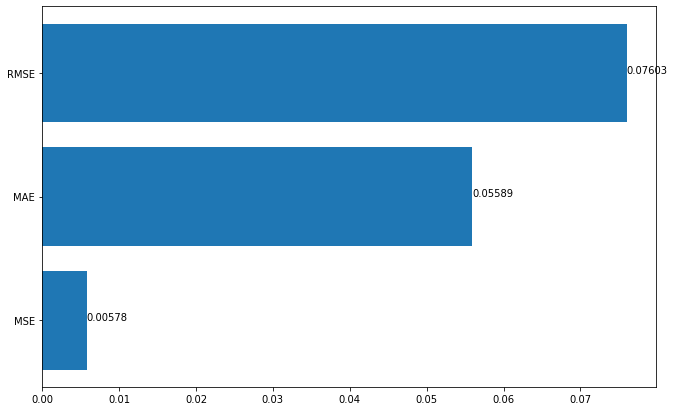

In [66]:
plt.figure(figsize = (11,7))
x = ["MSE","MAE","RMSE"]
y = [mse,mae,rmse]
plt.barh(x, y)
  
for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:7])
plt.show()